# Radial Distortion Correction
### This notebook was used to train the weights for the model.


Obtiaining the [dataset](http://groups.csail.mit.edu/vision/LabelMe/NewImages/indoorCVPR_09.tar)

In [ ]:
# !wget "http://groups.csail.mit.edu/vision/LabelMe/NewImages/indoorCVPR_09.tar" -O "./indoorimages.tar"

I've pre-downloaded to my drive:

In [ ]:
!cp "./drive/My Drive/Colab Notebooks/DistortionCorrection/indoorimages.tar" "./indoorimages.tar"
shutil.unpack_archive("indoorimages.tar", "./")
!rm "./indoorimages.tar"

## Importing necessary libraries<br>
[shutil](https://docs.python.org/3/library/shutil.html), [os](https://docs.python.org/3/library/os.html), [glob](https://docs.python.org/3/library/glob.html): for listing, extracting or archiving files<br>
[tensorflow](https://www.tensorflow.org/api_docs/python/), [tensorflow-addons](https://www.tensorflow.org/addons/api_docs/python/tfa), [numpy](https://numpy.org/doc/stable/): for matrix operations and deep learning<br>
[csv](https://docs.python.org/3/library/csv.html): for storing distorting coefficients<br>
others for other miscelleneous operations<br>

In [1]:
import shutil
import os
import glob

import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import csv
import matplotlib.pyplot as plt

import PIL
import random
import math
import datetime
import time

from tqdm.notebook import tqdm

import IPython

## Creating the data
Some constants:

In [2]:
TRAIN_SPLIT = 0.90 # train data for the network: 7682 images
VAL_SPLIT = 0.09 # data for runtime testing: 769 images
TEST_SPLIT = 0.01 # data for manual analysis: 85 images
#defining dimentions for the network
BATCH_SIZE = 32 
IMG_WIDTH = 512
IMG_HEIGHT = 512
CHANNELS = 3

Images were extracted and listed and those with geometic mean of sidelengths<256*sqrt(2) were discarded. The names of remaining were saved to disk.

In [ ]:
IMAGES_PATH ="./Images/"
IMAGES = []
for root, dirs, files in os.walk(IMAGES_PATH):
		IMAGES += [os.path.join(root,file) for file in files]
random.shuffle(IMAGES)

IMAGES_FILTER = []
minsize = 256*2**0.5
for fname in tqdm(IMAGES):
  a, b = plt.imread(fname).shape[:2]
  s = (a*b)**0.5 
  if s>=minsize:
    IMAGES_FILTER.append(fname)

m = len(IMAGES_FILTER)
TRAIN_IMAGES = IMAGES_FILTER[:int(m*TRAIN_SPLIT)]
VAL_IMAGES = IMAGES_FILTER[int(m*TRAIN_SPLIT):-int(m*TEST_SPLIT)]
TEST_IMAGES = IMAGES_FILTER[-int(m*TEST_SPLIT):]

with open('./drive/My Drive/Colab Notebooks/DistortionCorrection/train.txt','w') as f:
  f.writelines(map(lambda x:x+'\n', TRAIN_IMAGES))
with open('./drive/My Drive/Colab Notebooks/DistortionCorrection/val.txt','w') as f:
  f.writelines(map(lambda x:x+'\n', VAL_IMAGES))
with open('./drive/My Drive/Colab Notebooks/DistortionCorrection/test.txt','w') as f:
  f.writelines(map(lambda x:x+'\n', TEST_IMAGES))

Obtaining names of images from last step.

In [ ]:
TRAIN_IMAGES = []
VAL_IMAGES = []
TEST_IMAGES = []
with open('./drive/My Drive/Colab Notebooks/DistortionCorrection/train.txt','r') as f:
  TRAIN_IMAGES = list(map(str.strip, f.readlines()))
with open('./drive/My Drive/Colab Notebooks/DistortionCorrection/val.txt','r') as f:
  VAL_IMAGES = list(map(str.strip, f.readlines()))
with open('./drive/My Drive/Colab Notebooks/DistortionCorrection/test.txt','r') as f:
  TEST_IMAGES = list(map(str.strip, f.readlines()))
print('Number of train images:', len(TRAIN_IMAGES))
print('Number of validation images:', len(VAL_IMAGES))
print('Number of test images:', len(TEST_IMAGES))

Number of train images: 7682
Number of validation images: 769
Number of test images: 85


### Distorting images
Following are the functions implementing, eqns 1, 2 and 3 from [1].<br>
These are nominal, and too slow for ~8000 images. These are given just for understanding the following vectorized implementations.

In [ ]:
def mapinv(x1, y1, c, scale = 1, X=0.0,Y=0.0):
  mcr2 = scale-c*((x1-X)**2+(y1-Y)**2)
  return ((x1-X)/mcr2, (y1-Y)/mcr2)

def mapfor(x, y, c, scale = 1, X = 0.0, Y = 0.0):
  r2 = ((x-X)**2+(y-Y)**2)
  rcm2 = 2/((scale**2+4*c*r2)**0.5+scale)
  return ((x-X)*rcm2, (y-Y)*rcm2)

def scalemap(fn, x, y, c, inp_shape, out_shape, scale = 1, X=0, Y=0):
  x1, y1 = fn(x/out_shape[0]-0.5, y/out_shape[1]-0.5, c, scale, X, Y)
  x1=(x1+0.5)*inp_shape[0]
  y1=(y1+0.5)*inp_shape[1]
  return x1, y1

Vectorized implementation of the above functions using [tensorflow](https://www.tensorflow.org/api_docs/python/).

In [3]:
def idxarr(sx,sy):
  yidx, xidx = tf.meshgrid(tf.range(0,sy), tf.range(0,sx))
  idx = tf.stack([xidx,yidx], axis = -1)
  idx = tf.cast(idx, tf.float32)
  return idx
  
def scalemapinv_vect(idx, c):
  height = tf.shape(idx)[0]
  width = tf.shape(idx)[1]
  height = tf.cast(height, tf.float32)
  width = tf.cast(width, tf.float32)

  mapidx_xnorm = idx[..., 0]/height-0.5
  mapidx_ynorm = idx[..., 1]/width-0.5

  scale = 1+c/2
  r2 = tf.square(mapidx_xnorm)+tf.square(mapidx_ynorm)
  mcr2 = scale-c*r2

  mapidx_xscale = tf.divide(mapidx_xnorm, mcr2)
  mapidx_yscale = tf.divide(mapidx_ynorm, mcr2)

  mapidx_x = (mapidx_xscale+0.5)*height
  mapidx_y = (mapidx_yscale+0.5)*width
  mapidx = tf.stack([mapidx_x, mapidx_y], axis = -1)
  return mapidx

def scalemapfor_vect(idx, c):
  height = tf.shape(idx)[0]
  width = tf.shape(idx)[1]
  height = tf.cast(height, tf.float32)
  width = tf.cast(width, tf.float32)

  mapidx_xnorm = idx[..., 0]/height-0.5
  mapidx_ynorm = idx[..., 1]/width-0.5

  scale = 1-c/2
  r2 = tf.square(mapidx_xnorm)+tf.square(mapidx_ynorm)
  rcm2 = 2/(tf.sqrt(scale**2+4*c*r2)+scale)

  mapidx_xscale = tf.multiply(mapidx_xnorm, rcm2)
  mapidx_yscale = tf.multiply(mapidx_ynorm, rcm2)

  mapidx_x = (mapidx_xscale+0.5)*height
  mapidx_y = (mapidx_yscale+0.5)*width
  mapidx = tf.stack([mapidx_x, mapidx_y], axis = -1)
  return mapidx

Functions for distoring and undistorting an image using [desnse_image_warp](https://www.tensorflow.org/addons/api_docs/python/tfa/image/dense_image_warp) from [tensorflow-addons](https://www.tensorflow.org/addons/api_docs/python/tfa) 

In [4]:
@tf.function(experimental_relax_shapes=True)
def warp_distort(image, c, height, width):
  image = tf.cast(image, tf.float32)
  idx = idxarr(height, width)
  flow = idx-scalemapinv_vect(idx, c)
  return tfa.image.dense_image_warp(image = image[None, ...], flow = flow[None, ...])[0]

@tf.function(experimental_relax_shapes=True)
def warp_undistort(image, c, height, width):
  image = tf.cast(image, tf.float32)
  idx = idxarr(height, width)
  flow = idx-scalemapfor_vect(idx, c)
  tf.assert_rank(image, 3)
  return tfa.image.dense_image_warp(image = image[None, ...], flow = flow[None, ...])[0]

## Forming the input pipeline
Function that loads, distorts and resizes to fit the model's 512x512 input dimention with zero padding.

In [5]:
def ld_load_distort_unnorm(path):
  image = tf.io.read_file(path)
  try:
    if path[-3:] in ['jpg', 'JPG']:
      image = tf.image.decode_jpeg(image, channels = 3)
    elif path[-3:] in ['png', 'PNG']:
      image = tf.image.decode_png(image, channels = 3)
  except:
    image = tf.image.decode_image(image, channels=3)
  image = tf.squeeze(image)
  c = tf.random.uniform((1,))[0]
  height = tf.shape(image)[0]
  width = tf.shape(image)[1]
  image = warp_distort(image, c, height, width)
  image = tf.cast(tf.image.resize_with_pad(image, IMG_HEIGHT, IMG_WIDTH), tf.uint8)
  image = tf.reshape(image, [IMG_HEIGHT,IMG_WIDTH,3])
  return image, c

Calling the above function to preprocess all training data. This was done 4 times, each time training the model for ten epochs.

In [ ]:
#removing old values
!rm -rf ./procimages_train
!rm -rf ./imageattr_train.csv
!mkdir ./procimages_train

#distorting and saving to disk
start = 0
count = start
with open('./imageattr_train.csv', mode = ('w' if start == 0 else 'a'), newline='') as attr:
  attrwriter = csv.writer(attr)
  for fname in tqdm(TRAIN_IMAGES[start:]):
    image, c = ld_load_distort_unnorm(fname)
    PIL.Image.fromarray(image.numpy()).save(f'./procimages_train/img{count}.png')
    attrwriter.writerow([f'img{count}', c.numpy()])
    count+=1

#loading from disk
trainimgs = []
trainparams = []
with open('imageattr_train.csv') as attr:
  attrreader = csv.reader(attr)
  for row in attrreader:
    trainimgs.append('./procimages_train/'+row[0]+'.png')
    trainparams.append(float(row[1]))

#forming the input pipeline for the model
train_dataset = tf.data.Dataset.from_tensor_slices((trainimgs, trainparams))
train_dataset = train_dataset.map(loaddat, num_parallel_calls = tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(8)

Calling the above function to preprocess all validation data. This was done only one time to get consistent checking of accuracy.

In [ ]:
#removing old values
!rm -rf ./procimages_val
!rm -rf ./imageattr_val.csv
!mkdir ./procimages_val

#distorting and saving to disk
start = 0
count = start
with open('./imageattr_val.csv', mode = ('w' if start == 0 else 'a'), newline='') as attr:
  attrwriter = csv.writer(attr)
  for fname in tqdm(VAL_IMAGES[start:]):
    image, c = ld_load_distort_unnorm(fname)
    PIL.Image.fromarray(image.numpy()).save(f'./procimages_val/img{count}.png')
    attrwriter.writerow([f'img{count}', c.numpy()])
    count+=1

#loading from disk
valimgs = []
valparams = []
with open('imageattr_val.csv') as attr:
  attrreader = csv.reader(attr)
  for row in attrreader:
    valimgs.append('./procimages_val/'+row[0]+'.png')
    valparams.append(float(row[1]))

#forming the input pipeline for the model
val_dataset = tf.data.Dataset.from_tensor_slices((valimgs, valparams))
val_dataset = val_dataset.map(loaddat, num_parallel_calls = tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)

#function to load data in input pipeline
def loaddat(image, param):
  image = tf.io.read_file(image)
  image = tf.io.decode_png(image, channels = 3, dtype = tf.uint8)
  image = tf.cast(image, tf.float32)
  image = image/127.5 - 1
  return image, param

In [ ]:
# def loaddat(image, param):
#   image = tf.io.read_file(image)
#   image = tf.io.decode_png(image, channels = 3, dtype = tf.uint8)
#   image = tf.cast(image, tf.float32)
#   image = image/127.5 - 1
#   return image, param

# valimgs = []
# valparams = []
# with open('imageattr_val.csv') as attr:
#   attrreader = csv.reader(attr)
#   for row in attrreader:
#     valimgs.append('./procimages_val/'+row[0]+'.png')
#     valparams.append(float(row[1]))

# val_dataset = tf.data.Dataset.from_tensor_slices((valimgs, valparams))
# val_dataset = val_dataset.map(loaddat, num_parallel_calls = tf.data.experimental.AUTOTUNE)

## Creating the model
The model consists of a [Xception network](https://arxiv.org/abs/1610.02357)  \(pre trained on [imagenet](http://www.image-net.org/)), followed by some Convolutional layers and finally connected to a dense layers outputing one value.<br>
The output of the Xception network is multiplied by a radial matrix (a trick used in [2]) to emphasize areas facing higher effects of distortion.

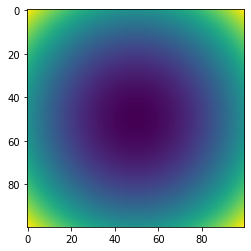

In [6]:
#function to create the radial matrix
def get_radial_mat(n, m, normalized = False):
  radial_mat = np.fromfunction(lambda i,j:(i-(n-1)/2)**2+(j-(n-1)/2)**2, (n, n))
  if not normalized:
    return radial_mat
  else:
    radial_mat_norm = radial_mat.copy()
    return (radial_mat_norm-np.mean(radial_mat_norm))/np.std(radial_mat_norm)

radial_mat = get_radial_mat(100, 100)
_ = plt.imshow(radial_mat/np.max(radial_mat))

In [7]:
# Creating the model
try:
  del model
except:
  pass
tf.keras.backend.clear_session()
def make_model_large2():
  pre_trained_model = tf.keras.applications.Xception(include_top = False, input_shape = (512, 512, 3), weights = 'imagenet')
  for layer in pre_trained_model.layers:
    layer.trainable = False
  last_layer = pre_trained_model.get_layer('block13_sepconv2_bn')
  last_output = last_layer.output
  radial_mat = get_radial_mat(32, 32, normalized = False)
  x = tf.keras.layers.Lambda(lambda x: tf.multiply(x, radial_mat[None, ..., None]))(last_output)
  x = tf.keras.layers.Conv2D(512, (3, 3), strides = 2, padding = 'same', activation = 'relu')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2D(128, (3, 3), strides = 2, padding = 'same', activation = 'relu')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2D(64, (3, 3), strides = 2, padding = 'same', activation = 'relu')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(128, activation = 'relu')(x)
  x = tf.keras.layers.Dropout(0.05)(x)
  x = tf.keras.layers.Dense(1)(x)
  return tf.keras.Model(pre_trained_model.input, x)

model = make_model_large2()
model.compile(optimizer = tf.keras.optimizers.Adam(1.8e-3), loss = 'mae')

83689472/83683744 [==============================] - 3s 0us/step


In [ ]:
#summary of the model
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 255, 255, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 255, 255, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 255, 255, 32) 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

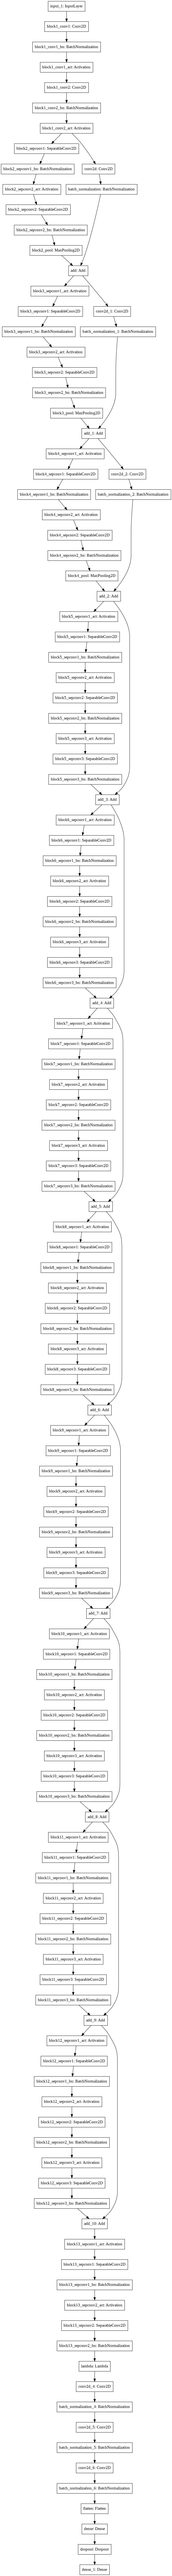

In [ ]:
#a display of the model
tf.keras.utils.plot_model(model)

In [ ]:
# callback for saving checkpoints
class WeightsSaver(tf.keras.callbacks.Callback):
  def __init__(self, folderpath, N = -1):
    self.N = N
    self.folderpath = folderpath
    try:
      os.makedirs(folderpath)
    except FileExistsError:
      print('Warning! overiting old checkpoints')

  def on_epoch_end(self, epoch, logs={}):
    if not self.N==-1:
      if (epoch+1) % self.N == 0:
        self.model.save_weights(os.path.join(self.folderpath, f"epoch_{epoch+1}_weights.h5"))

  def on_train_end(self, logs = {}):
    self.model.save_weights(os.path.join(self.folderpath, f"epoch_final_weights.h5"))

In [ ]:
callbacks = [WeightsSaver("./train_checkpoints/")]

## Training the model
training the model, this was run 4 times by rerunning the training data creation above

In [ ]:
history = model.fit(train_dataset, epochs=10, callbacks = callbacks, validation_data=val_dataset, verbose=2)

Epoch 1/10
241/241 - 186s - loss: 0.1201 - val_loss: 0.1343
Epoch 2/10
241/241 - 185s - loss: 0.0981 - val_loss: 0.1453
Epoch 3/10
241/241 - 185s - loss: 0.0898 - val_loss: 0.1296
Epoch 4/10
241/241 - 185s - loss: 0.0824 - val_loss: 0.1928
Epoch 5/10
241/241 - 185s - loss: 0.0801 - val_loss: 0.1711
Epoch 6/10
241/241 - 185s - loss: 0.0756 - val_loss: 0.1390
Epoch 7/10
241/241 - 185s - loss: 0.0708 - val_loss: 0.1484
Epoch 8/10
241/241 - 185s - loss: 0.0693 - val_loss: 0.1525
Epoch 9/10
241/241 - 185s - loss: 0.0693 - val_loss: 0.1459
Epoch 10/10
241/241 - 185s - loss: 0.0684 - val_loss: 0.1445


## Saving final weights
The final weights were copied to be used in the application.

In [ ]:
!cp "./train_checkpoints/epoch_final_weights.h5" "./drive/My Drive/Colab Notebooks/DistortionCorrection/epoch_final_weights.h5"

## Finding Error in the predictions
Percentage Absolute Error:

In [1]:
shutil.unpack_archive("./test.zip", "./")
TEST_FILES = ["./test/"+fname for fname in os.listdir("./test")]
for fname in TEST_FILES*10:
  img, c = ld_load_distort_unnorm(fname)
  chat = tf.squeeze(model(img[None, ...]))
  prerr = (100*tf.abs(chat-c)/c).numpy()
  errors.append(prerr)
  
print(np.mean(errors))

9.5981479

## References
Main references:

[1] [A new algorithm to correct fish-eye-...](https://ieeexplore.ieee.org/document/958994) <br>
[2] [Deep Convolutional Neural Networks for es...](https://www.researchgate.net/publication/335126536_Deep_Convolutional_Neural_Networks_for_estimating_lens_distortion_parameters) <br>
[3] [Xception: Deep Learning with Depthwise Se..](https://www.researchgate.net/publication/320968382_Xception_Deep_Learning_with_Depthwise_Separable_Convolutions)